# SV caller

U ovoj vežbi, analizira se jedna poravnata sekvenca u cilju detekcije strukturnih varijanti. Primenjuju se dva metoda detekcije, dubina read-ova i podeljeni read-ovi. Ako ste entuzijastični, u slobodno vreme slobodno probajte da implementirate i neki od ostalih metoda (RP ili assembly).

U slučaju da nemate instalirano, najpre instaliramo potrebne biblioteke, u ovom slučaju pysam - paket za rad sa poravnatim sekvencama. Osim poravnatih sekvenci (SAM, BAM, CRAM), pysam omogućava rad i sa fajlovima za čuvanje informacija o varijantama (VCF, BCF). Pored pysam paketa, koristićemo i matplotlib za vizualizaciju. U slučaju da želite lepše grafike, slobodno pogledajte i [seaborn](https://seaborn.pydata.org/) i [bokeh](https://bokeh.org/)

pysam - [dokumentacija](https://pysam.readthedocs.io/en/latest/api.html)

In [2]:
# !pip install pysam

In [3]:
import pysam # Za interakciju sa BAM fajlovima
import matplotlib.pyplot as plt # Za grafik

### Učitavanje podataka

Najpre učitavamo poravnatu sekvencu. Sekvenca je sadržana u BAM fajlu. BAM je kompresovani SAM (sequence alignment map) fajl. Više o formatu možete naći na [linku](https://samtools.github.io/hts-specs/SAMv1.pdf). BAM fajl je proizvod poravnanja i sadrži informacije o tome gde se svaka sekvenca (svaki read) iz FASTA fajla poravnava. Pored toga, sadrži i dodatne informacije o kvalitetu poravnanja, kao i o tipu poravnanja (da li se savršeno poklapa, da li se poklapa iz više delova, itd..)

U ovoj vežbi, za interakciju sa BAM fajlom koristimo pysam biblioteku. Pravimo AlignmentFile objekat:

In [6]:
# alignment_file_path = "/sbgenomics/project-files/simulated_somatic.bam"
alignment_file_path = "./simulated_somatic.bam"

alignment = pysam.AlignmentFile(alignment_file_path, "rb")
alignment

Pogledajmo na koje se sve hromozome poravnavaju readovi sadržani u BAM fajlu:

In [8]:
print("Hromozomi iz BAM fajla: {}".format(alignment.references))

Hromozomi iz BAM fajla: ('20',)


Dakle, postoji samo jedan hromozom. To će nam olakšati dalji rad. 

### Read depth pristup

Ideja:
* Pravimo niz intervala od N baznih parova
* Za svaki interval pogledamo koliko se read-ova nalazi na tom intervalu
* Plotujemo zavisnost dubine read-ova od broja baznih parova

In [9]:
# Računamo read depth u prozorima dužine 5 baznih parova da smanjimo šum
interval_length = 5

# Kako bismo napravili listu intervala, bitno nam je da znamo dužinu našeg hromozoma
# Znamo da imamo samo jedan hromozom u BAM fajlu, tako da znamo da nas zanima dužina prvog hromozoma (hromozoma 20)
reference_length = alignment.lengths[0] 

# Pravimo listu granica intervala
intervals = [i*interval_length for i in range(round(reference_length / interval_length))]

# Brojimo read-ove u svakom intervalu
# Koristimo AlignmentFile.fetch metod da dohvatimo sve readove koji se mapiraju na hromozom 20 između start i end koordinata
read_depth = [
    len(list(alignment.fetch('20', start, end))) 
    for start, end in zip(intervals[1:-1], intervals[2:])
]

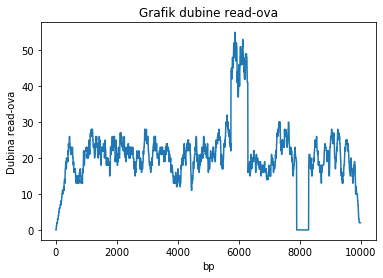

In [10]:
# Plotujemo read depth našeg genoma
plt.plot(intervals[1:-1], read_depth)
plt.xlabel('bp')
plt.ylabel('Dubina read-ova')
plt.title('Grafik dubine read-ova')
plt.show()

Prethodni grafik nam ne daje specifične informacije o postojanju i dužinama varijanti, već samo osećaj o tome kako se ponaša dubina read-ova. Vidimo nekoliko stvari. Najpre, i sa prozorom od 5 nukleotida, naš signal je i dalje zašumljen. Drugo, izgleda da postoje dve strukturne varijante, jedna duplikacija na oko 6kbp, i jedna delecija na oko 8kbp.

Kako objašnjavamo ponašanje dubine read-ova na početku i na kraju hromozoma?

Kako ćemo sada napraviti caller?

### CNV caller

Isprobaćemo dva pristupa: 
1. Prvi pristup posmatra relativnu promenu između susednih prozora. Ukoliko postoji drastična promena u dubini read-ova, taj prozor označava početak, odnosno kraj varijante.
2. Drugi pristup posmatra trenutnu dubinu read-ova u odnosu na medijanu ovog signala.

#### Prvi pristup - relativna promena

In [11]:
# Pravimo jednostavan caller delecija i duplikacija:
average_coverage = sum(read_depth)/len(read_depth)
previous_depth = read_depth[0]
deletion_start = 0
duplication_start = 0

SVs = {
    'DEL': [],
    'DUP': []
}
# Kako cemo da definisemo pocetak SV?
# Hajde da se dogovorimo da je neophodna promena u read depth-u od bar 30% average coverage-a
# Probajte i sa drugim vrednostima
threshold = 0.3 * average_coverage

for curr_bin, depth in enumerate(read_depth):
    if depth - previous_depth < -threshold and not(deletion_start):
        if duplication_start:
            SVs['DUP'].append((duplication_start * interval_length, curr_bin * interval_length))
            duplication_start = 0
        else:
            deletion_start = curr_bin
    if depth - previous_depth > threshold and not(duplication_start):
        if deletion_start:
            SVs['DEL'].append((deletion_start * interval_length, curr_bin * interval_length))
            deletion_start = 0
        else:
            duplication_start = curr_bin
    previous_depth = depth


In [12]:
print(SVs)

{'DEL': [(7895, 8290)], 'DUP': [(5740, 6295)]}


#### Drugi pristup - medijana

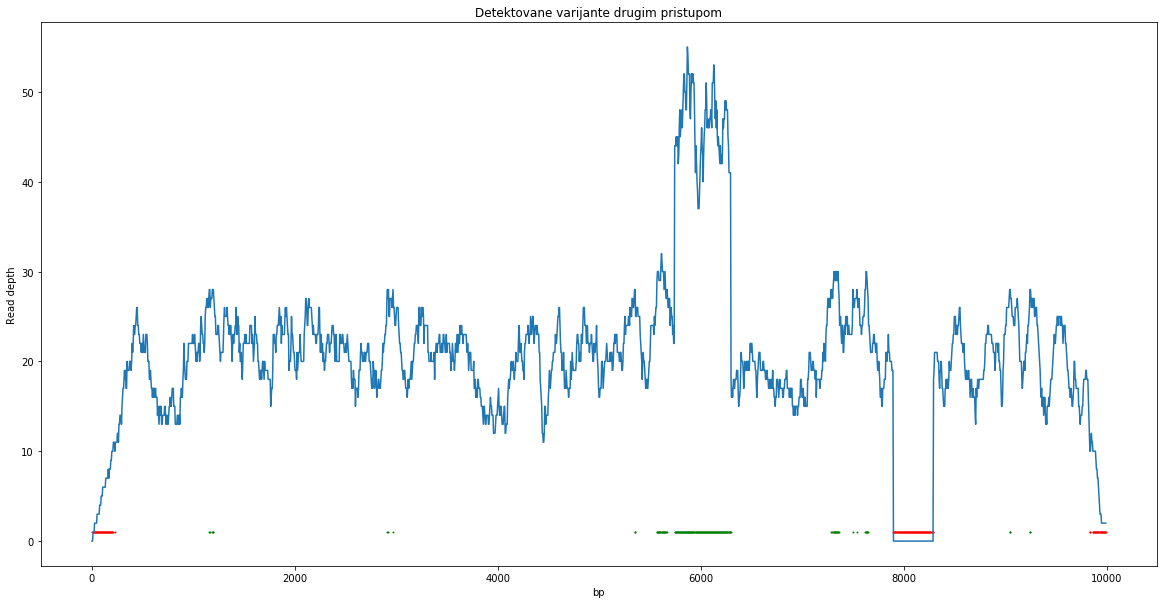

In [38]:
import numpy as np


medijana = np.mean(read_depth)
np_intervals = np.asarray(intervals[1:-1])
np_read_depth = np.asarray(read_depth)
deletions = np_read_depth < 0.5*medijana
duplications = np_read_depth > 1.33*medijana

plt.figure(figsize=(20,10))
plt.plot(np_intervals, read_depth)
plt.scatter(np_intervals[deletions], deletions[deletions], c='red', s=1)
plt.scatter(np_intervals[duplications], duplications[duplications], c='green', s=1)
plt.xlabel('bp')
plt.ylabel('Read depth')
plt.title('Detektovane varijante drugim pristupom')
plt.show()

### Split reads pristup

Ovaj pristup zahteva razumevanje CIGAR stringova. Za to pogledajte specifikaciju SAM, odnosno BAM fajlova. Ono što nas trenutno zanima je da li postoje CIGAR stringovi koji sadrže *S* karakter (indikacija podeljenog read-a). Takođe, zanima nas da li je druga polovina read-a ili prva polovina splitovana kako bismo mogli precizno da odredimo koordinatu potencijalnog breakend-a.

In [14]:
# U ovom pristupu ćemo koristiti neke druge informacije koje se nalaze u BAM fajlu
# Najpre dohvatamo sve readove iz fajla:
alignments = alignment.fetch('20')
breakpoints = []
for read in alignments:
    # Svaki read je AlignedSegment objekat: https://pysam.readthedocs.io/en/latest/api.html#pysam.AlignedSegment
    # Ovaj objekat sadrži sve informacije koje su zapisane za jedan read (vidi SAM dokumentaciju)
    # Konkretno zanimaju nas informacije koje se nalaze u CIGAR stringu (vidi prezentaciju)
    if 'S' in read.cigarstring and not read.is_secondary:
        cigar = read.cigarstring
        start = read.reference_start
        if cigar.find('M') < cigar.find('S'):
            location = int(cigar.split('M')[0])
            breakpoints.append(start + location)
        elif cigar.find('S') < cigar.find('M'):
            breakpoints.append(start + 1)

# Ovakav pristup nam ne govori da li se breakend (mesto pucanja hromozoma) 
# odnosi na pocetak ili kraj varijante, ni koji je tip varijante u pitanju.
# Za odgovor na ova pitanja bilo bi potrebno malo izmeniti algoritam, ili
# ga kombinovati sa drugim algoritmima detekcije strukturnih varijanti
print(set(breakpoints))

{8300, 6300, 5750, 6297, 7900}


In [ ]:
# Za dobrovoljni domaći:

# Probajte da detektujete delecije pomoću read pair algoritma
# U dokumentaciji za pysam možete naći kako za zadati read možete da otkrijete gde se mapira njegov par
# Uzorak je napravljen tako da dužina fragmenata dolazi iz normalne raspodele mean=350, std=50
# Ideje iza read pair algoritma su obrazložene u prezentaciji
# Srećno!